# Importing the dependencies !

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import requests
from io import StringIO

# Importing the Boston House Price Dataset !

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
response = requests.get(data_url)

if response.status_code == 200:
    data_str = response.text
    
    # Diviser le contenu en lignes
    lines = data_str.splitlines()

    # Ignorer les 22 premières lignes
    lines = lines[22:]
    
    combined_lines = []

    i = 0
    while i < len(lines):
        current_line = lines[i].strip().split()
        
        # Si la ligne suivante est la continuation de la ligne actuelle, les combiner
        if len(current_line) < 14:
            next_line = lines[i + 1].strip().split()
            current_line.extend(next_line)
            i += 1  # Sauter la ligne suivante car elle a été combinée

        combined_lines.append(" ".join(current_line))
        i += 1

    # Joindre les lignes combinées en une chaîne
    combined_data = "\n".join(combined_lines)
    
    # Utiliser StringIO pour traiter les données comme un fichier CSV
    raw_df = pd.read_csv(StringIO(combined_data), sep=" ", header=None)
    
else:
    print(f"Erreur : impossible de télécharger le fichier, statut {response.status_code}")

In [3]:
column_names = [
    "CRIM",    # per capita crime rate by town
    "ZN",      # proportion of residential land zoned for lots over 25,000 sq.ft.
    "INDUS",   # proportion of non-retail business acres per town
    "CHAS",    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    "NOX",     # nitric oxides concentration (parts per 10 million)
    "RM",      # average number of rooms per dwelling
    "AGE",     # proportion of owner-occupied units built prior to 1940
    "DIS",     # weighted distances to five Boston employment centres
    "RAD",     # index of accessibility to radial highways
    "TAX",     # full-value property-tax rate per $10,000
    "PTRATIO", # pupil-teacher ratio by town
    "B",       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    "LSTAT",   # % lower status of the population
    "MEDV"     # Median value of owner-occupied homes in $1000's
]

In [4]:
raw_df.columns = column_names

# mv MEDV PRICE

In [5]:
raw_df.rename(columns={"MEDV": "PRICE"}, inplace=True)

In [6]:
raw_df.shape

(506, 14)

# Check for missing values !

In [7]:
raw_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64

# Statistical measures of the dataset !

In [8]:
raw_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


#  Understanding the correlation between various features in the dataset !

In [9]:
correlation = raw_df.corr()
correlation

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


# Constructing a heatmap (carte thermique) to understand the correlation !

<Axes: >

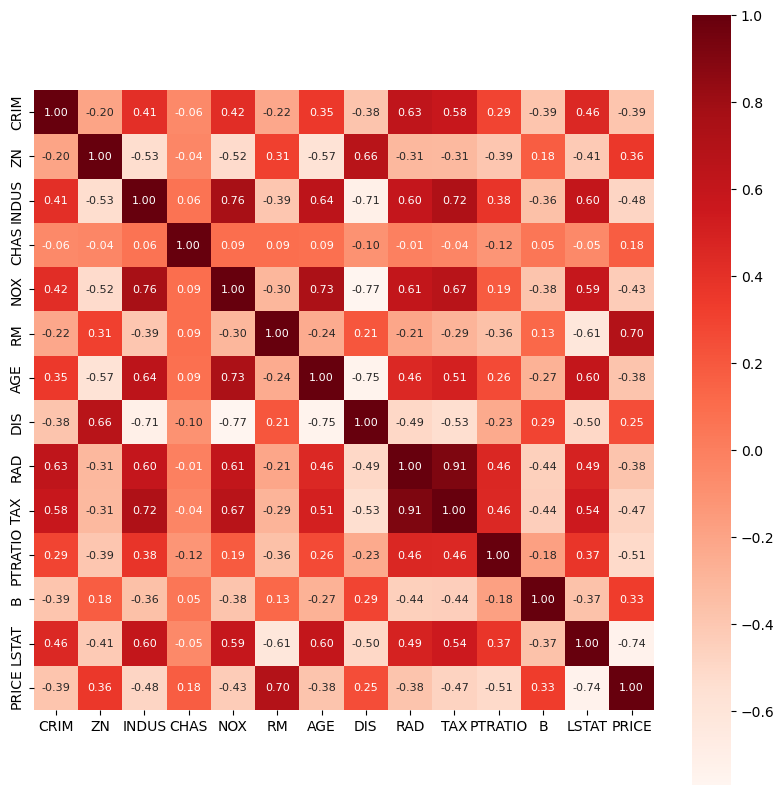

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size':8}, cmap='Reds')

# Splitting the data and Target !

In [11]:
X = raw_df.drop(['PRICE'], axis=1)
y = raw_df['PRICE']

# Splitting the data into Training data and Test Data !

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# Model Training : XGBoost Regressor

In [13]:
model = XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluation
## Prediction on training data !
### accuracy for prediction on training data !

In [14]:
training_data_prediction = model.predict(X_train)
training_data_prediction

array([23.112196 , 20.992601 , 20.10438  , 34.67932  , 13.920501 ,
       13.499354 , 21.998383 , 15.206723 , 10.89543  , 22.67402  ,
       13.795236 ,  5.602332 , 29.808502 , 49.98666  , 34.89634  ,
       20.594336 , 23.388903 , 19.2118   , 32.69294  , 19.604128 ,
       26.978151 ,  8.405952 , 46.00062  , 21.70406  , 27.084402 ,
       19.372278 , 19.297894 , 24.79984  , 22.608278 , 31.707775 ,
       18.53683  ,  8.703393 , 17.40025  , 23.698814 , 13.29729  ,
       10.504759 , 12.693588 , 24.994888 , 19.694864 , 14.911037 ,
       24.20254  , 24.991112 , 14.901547 , 16.987965 , 15.592753 ,
       12.704759 , 24.505623 , 15.007718 , 49.999355 , 17.509344 ,
       21.18844  , 31.999287 , 15.606071 , 22.902134 , 19.309835 ,
       18.697083 , 23.302961 , 37.19767  , 30.102247 , 33.117855 ,
       20.993683 , 50.00471  , 13.40048  ,  5.002565 , 16.50862  ,
        8.4016905, 28.651423 , 19.49218  , 20.595366 , 45.404697 ,
       39.808857 , 33.4055   , 19.81498  , 33.406376 , 25.3020

#### R Squared Error (Coefficient de determination)

In [15]:
score_1 = metrics.r2_score(Y_train, training_data_prediction)
score_1

0.9999980039471451

#### Mean Absolute Error

In [16]:
score_2 = metrics.mean_absolute_error(Y_train, training_data_prediction)
score_2

0.0091330346494618

#### Prediction on Test Data !

In [18]:
test_data_prediction = model.predict(X_test)

In [19]:
score_1 = metrics.r2_score(Y_test, test_data_prediction)
score_2 = metrics.mean_absolute_error(Y_test, test_data_prediction)

print(score_1)
print(score_2)

0.9051721149855378
2.0748727686264927


#### Visualizing the actual Prices and predicted prices !

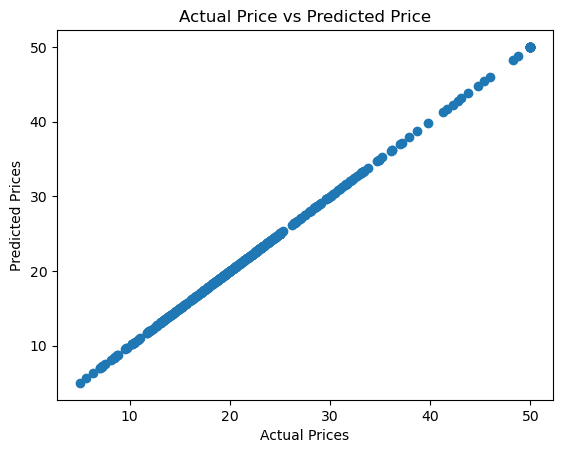

In [20]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Price vs Predicted Price")
plt.show()